In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 128
latent_dim = 2
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [4]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

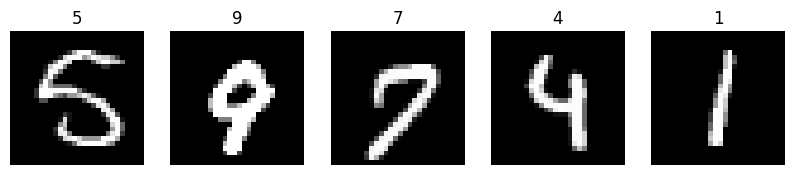

In [5]:
trainX = train_dataset.data.numpy()
trainy = train_dataset.targets.numpy()
plt.figure(figsize=(10,2))
for j in range(5):
    i = np.random.randint(0, len(trainX))
    plt.subplot(1,5,j+1)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainy[i])
    plt.axis('off')
plt.show()


In [6]:



class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 64, 5)
        self.enc_conv2 = nn.Conv2d(64, 64, 3)
        self.enc_conv3 = nn.Conv2d(64, 32, 3)
        self.fc_hidden = nn.Linear(32 * 1 * 1, 16)
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 64)
        self.decconv1 = nn.ConvTranspose2d(64, 64, 3)
        self.decconv2 = nn.ConvTranspose2d(64, 64, 3)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.deconv3 = nn.ConvTranspose2d(64, 64, 3)
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.deconv_out = nn.ConvTranspose2d(64, 1, 5)

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.enc_conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.enc_conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_hidden(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.fc_dec(z))
        x = x.view(-1, 64, 1, 1)

        x = F.relu(self.decconv1(x))
        x = F.relu(self.decconv2(x))
        x = self.upsample1(x)
        x = F.relu(self.deconv3(x))
        x = self.upsample2(x)
        x = torch.sigmoid(self.deconv_out(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [7]:

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    B, C, H, W = x.size()
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    recon_loss = recon_loss * H * W
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss


In [8]:

vae = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)


In [9]:

print("Starting training...")
vae.train()
for epoch in range(epochs):
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0

    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()

        recon, mu, logvar = vae(x)
        loss, recon_loss, kl_loss = vae_loss(recon, x, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = train_recon_loss / len(train_loader.dataset)
    avg_kl = train_kl_loss / len(train_loader.dataset)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Total Loss: {avg_loss:.4f}')
        print(f'  Recon Loss: {avg_recon:.4f}')
        print(f'  KL Loss: {avg_kl:.4f}')

print("Training completed!")


Starting training...
Epoch 5/50:
  Total Loss: 0.2899
  Recon Loss: 0.2698
  KL Loss: 0.0201
Epoch 10/50:
  Total Loss: 0.2779
  Recon Loss: 0.2563
  KL Loss: 0.0216
Epoch 15/50:
  Total Loss: 0.2724
  Recon Loss: 0.2501
  KL Loss: 0.0223
Epoch 20/50:
  Total Loss: 0.2696
  Recon Loss: 0.2469
  KL Loss: 0.0227
Epoch 25/50:
  Total Loss: 0.2671
  Recon Loss: 0.2442
  KL Loss: 0.0229
Epoch 30/50:
  Total Loss: 0.2660
  Recon Loss: 0.2429
  KL Loss: 0.0231
Epoch 35/50:
  Total Loss: 0.2644
  Recon Loss: 0.2413
  KL Loss: 0.0232
Epoch 40/50:
  Total Loss: 0.2631
  Recon Loss: 0.2397
  KL Loss: 0.0234
Epoch 45/50:
  Total Loss: 0.2618
  Recon Loss: 0.2384
  KL Loss: 0.0235
Epoch 50/50:
  Total Loss: 0.2613
  Recon Loss: 0.2378
  KL Loss: 0.0235
Training completed!


In [10]:

vae.eval()

test_images = []
test_labels = []
for img, label in test_dataset:
    test_images.append(img.numpy())
    test_labels.append(label)

test_images = np.array(test_images)
test_labels = np.array(test_labels)


In [11]:
def get_latent_code(model, x):
    if isinstance(x, np.ndarray):
        x = torch.tensor(x, dtype=torch.float32)
    x = x.unsqueeze(0).to(device)

    with torch.no_grad():
        mu, logvar = model.encode(x)
        z = mu
    return z.cpu().numpy()[0]

def interpolate_codes(z1, z2, num_steps=9):
    interpolates = []
    for alpha in np.linspace(0, 1, num_steps):
        z = (1 - alpha) * z1 + alpha * z2
        interpolates.append(z)
    return np.array(interpolates)

def decode_latent(model, z_array):
    model.eval()
    decoded_images = []
    with torch.no_grad():
        for z in z_array:
            z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0).to(device)
            x_hat = model.decode(z_tensor)
            decoded_images.append(x_hat.cpu().squeeze().numpy())
    return np.array(decoded_images)


In [12]:


def plot_interpolations(pairs, title, save_path=None):
    rows = len(pairs)
    cols = 9
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.2, rows * 1.2))

    if rows == 1:
        axes = axes.reshape(1, -1)

    for i, (idx1, idx2) in enumerate(pairs):
        z1 = get_latent_code(vae, test_images[idx1])
        z2 = get_latent_code(vae, test_images[idx2])

        interps = interpolate_codes(z1, z2, num_steps=cols)
        decoded_imgs = decode_latent(vae, interps)

        for j in range(cols):
            ax = axes[i, j] if rows > 1 else axes[j]
            ax.imshow(decoded_imgs[j], cmap='gray')
            ax.axis('off')

            if j == 0:
                ax.set_title(f'Digit {test_labels[idx1]}', fontsize=8)
            elif j == cols - 1:
                ax.set_title(f'Digit {test_labels[idx2]}', fontsize=8)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def visualize_latent_space(model, test_loader, num_samples=1000):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            if i * batch_size >= num_samples:
                break

            x = x.to(device)
            mu, _ = model.encode(x)
            latents.append(mu.cpu().numpy())
            labels.append(y.numpy())

    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('2D Latent Space Visualization')
    plt.grid(True, alpha=0.3)
    plt.show()


Generating same digit interpolations...


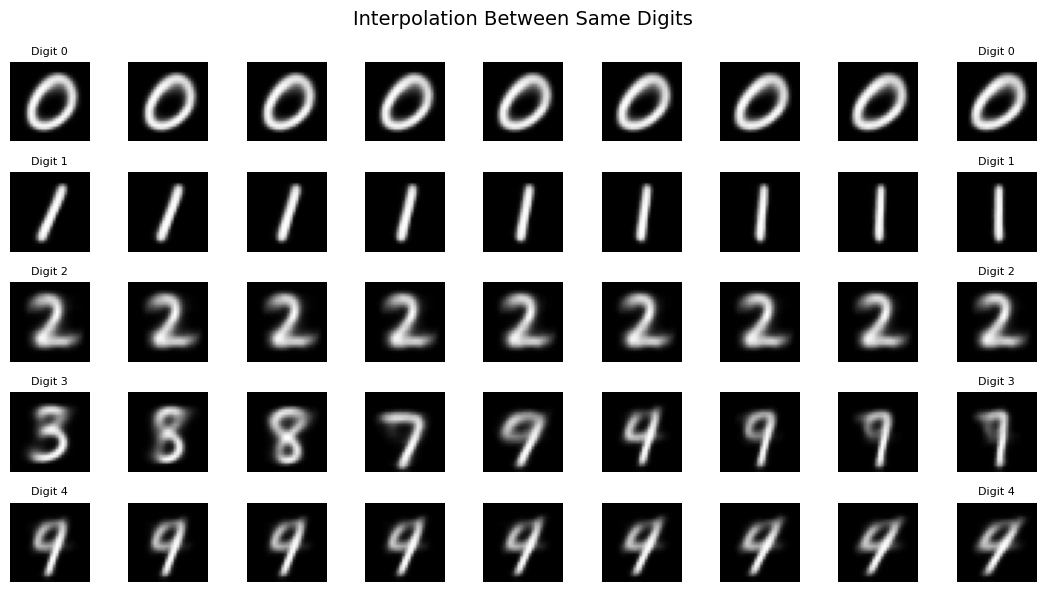

In [13]:

print("Generating same digit interpolations...")
same_digit_pairs = []
np.random.seed(42)

for digit in range(10):
    digit_indices = np.where(test_labels == digit)[0]
    if len(digit_indices) >= 2:
        selected = np.random.choice(digit_indices, size=2, replace=False)
        same_digit_pairs.append(tuple(selected))
    if len(same_digit_pairs) >= 5:
        break

plot_interpolations(same_digit_pairs, "Interpolation Between Same Digits")


Generating different digit interpolations...


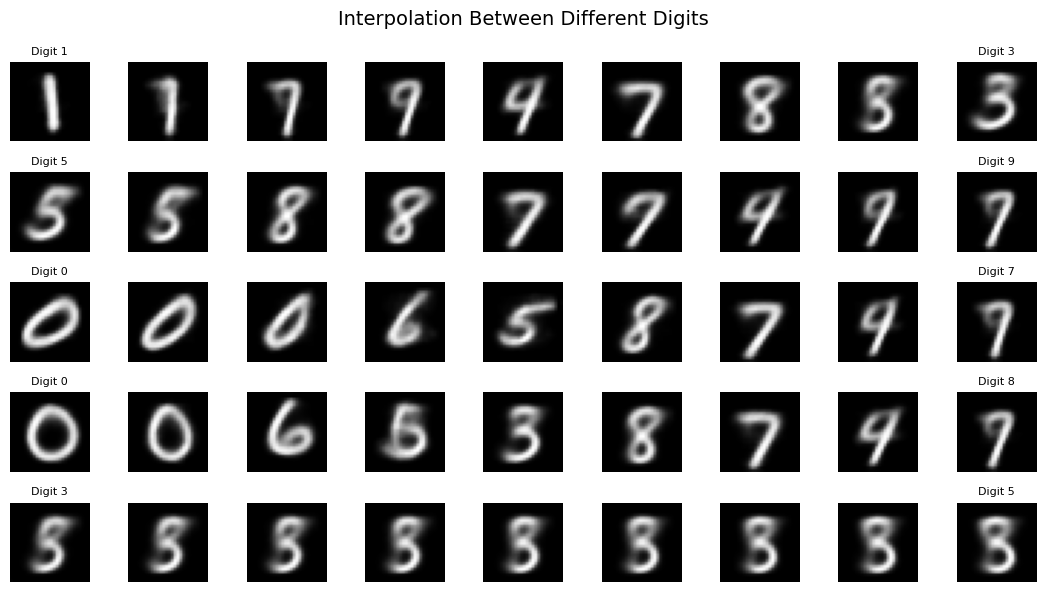

In [14]:

print("Generating different digit interpolations...")
different_digit_pairs = []
attempts = 0
while len(different_digit_pairs) < 5 and attempts < 100:
    idx1, idx2 = np.random.choice(len(test_labels), size=2, replace=False)
    if test_labels[idx1] != test_labels[idx2]:
        different_digit_pairs.append((idx1, idx2))
    attempts += 1

plot_interpolations(different_digit_pairs, "Interpolation Between Different Digits")


Visualizing latent space...


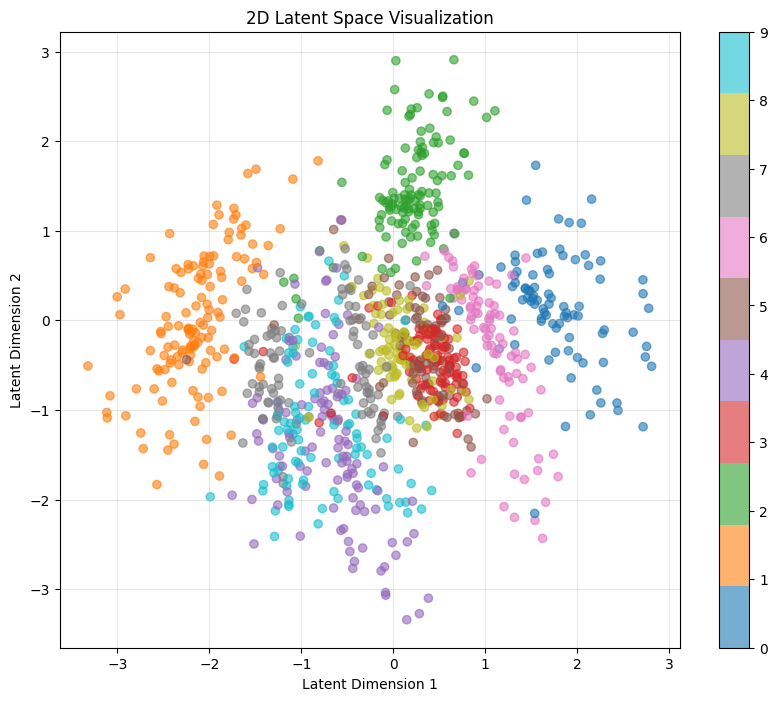

In [15]:


print("Visualizing latent space...")
visualize_latent_space(vae, test_loader)


Generating random samples...


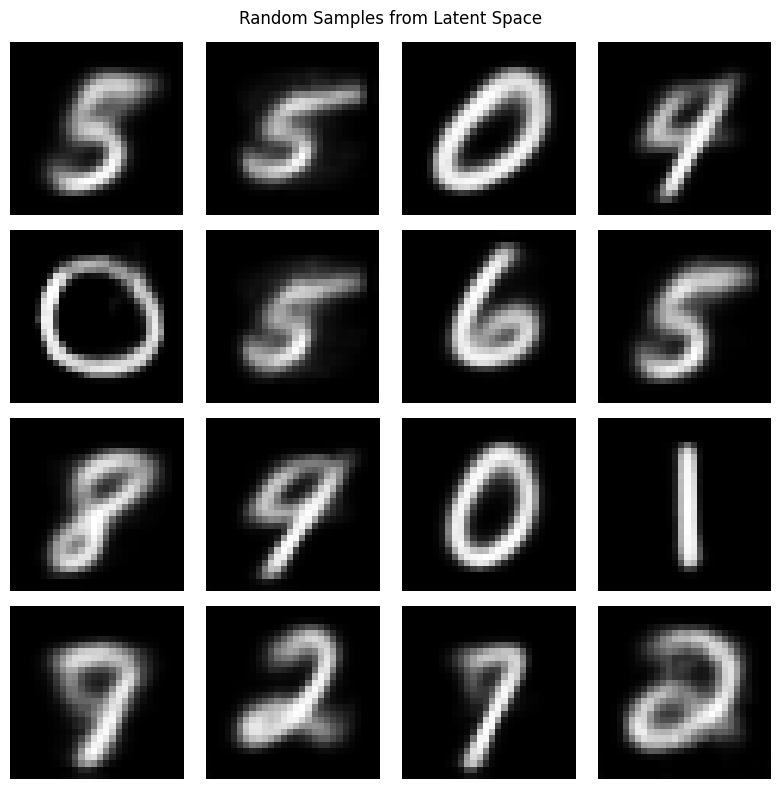

In [16]:

print("Generating random samples...")
def generate_random_samples(model, num_samples=16):
    """Generate random samples from the learned distribution"""
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z)
        samples = samples.cpu().numpy()

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = samples[i].squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.suptitle('Random Samples from Latent Space')
    plt.tight_layout()
    plt.show()

generate_random_samples(vae)